In [139]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.tools as tls

In [140]:
dataset = pd.read_csv('All_GPUs.csv')

In [141]:
dataset.head()

,Architecture,Best_Resolution,Boost_Clock,Core_Speed,DVI_Connection,Dedicated,Direct_X,DisplayPort_Connection,HDMI_Connection,Integrated,...,Process,ROPs,Release_Date,Release_Price,Resolution_WxH,SLI_Crossfire,Shader,TMUs,Texture_Rate,VGA_Connection
0,Tesla G92b,NaN,NaN,738 MHz,2.0,Yes,DX 10.0,NaN,0.0,No,...,55nm,16,\n01-Mar-2009,NaN,2560x1600,Yes,4.0,64.0,47 GTexel/s,0.0
1,R600 XT,1366 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,80nm,16,\n14-May-2007,NaN,2560x1600,Yes,4.0,16.0,12 GTexel/s,0.0
2,R600 PRO,1366 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,80nm,16,\n07-Dec-2007,NaN,2560x1600,Yes,4.0,16.0,10 GTexel/s,0.0
3,RV630,1024 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,65nm,4,\n01-Jul-2007,NaN,2560x1600,Yes,4.0,8.0,7 GTexel/s,0.0
4,RV630,1024 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,65nm,4,\n28-Jun-2007,NaN,2560x1600,Yes,4.0,8.0,6 GTexel/s,0.0


In [142]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3406 entries, 0 to 3405
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Architecture            3344 non-null   object 
 1   Best_Resolution         2764 non-null   object 
 2   Boost_Clock             1446 non-null   object 
 3   Core_Speed              3406 non-null   object 
 4   DVI_Connection          2656 non-null   float64
 5   Dedicated               3392 non-null   object 
 6   Direct_X                3400 non-null   object 
 7   DisplayPort_Connection  857 non-null    float64
 8   HDMI_Connection         2643 non-null   float64
 9   Integrated              3392 non-null   object 
 10  L2_Cache                3406 non-null   object 
 11  Manufacturer            3406 non-null   object 
 12  Max_Power               2781 non-null   object 
 13  Memory                  2986 non-null   object 
 14  Memory_Bandwidth        3285 non-null   

<AxesSubplot:>

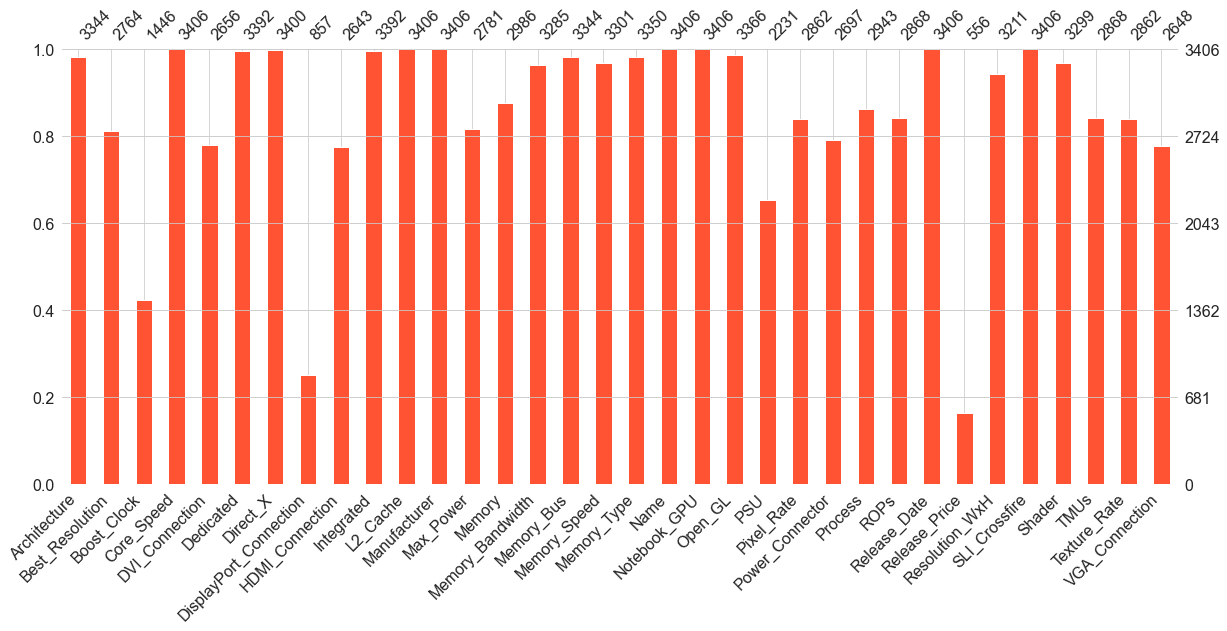

In [143]:
import missingno as msno
# Nullity or missing values by columns
#msno.matrix(df=dataset, figsize=(20, 8), color=(255/255, 83/255, 51/255))
msno.bar(df=dataset, figsize=(20, 8), color=(255/255, 83/255, 51/255))

In [144]:
key_columns = ['Best_Resolution', 'Core_Speed', 'Manufacturer', 'Memory', 'Memory_Bandwidth', 'Name', 'Release_Date']
dataset = dataset[key_columns]

In [145]:
dataset['Release_Date']=dataset['Release_Date'].str[1:-1]
dataset=dataset[dataset['Release_Date'].str.len()==11]
dataset['Release_Date']=pd.to_datetime(dataset['Release_Date'], format='%d-%b-%Y')
dataset['Release_Year']=dataset['Release_Date'].dt.year
dataset['Release_Month']=dataset['Release_Date'].dt.month
dataset['Release']=dataset['Release_Year'] + dataset['Release_Month']/12

In [146]:
dataset['Memory'] = dataset['Memory'].str[:-3].fillna(0).astype(int)
print(type(dataset['Memory_Bandwidth'][0]))
dataset['Memory_Bandwidth']=dataset['Memory_Bandwidth'].str[:-6].fillna(0).astype(float)

<class 'str'>


In [147]:
fin_data=dataset.to_csv("fin_dataaa.csv")

In [98]:
def countPixels(x):
    if pd.isnull(x):
        return 800*600;
    else:
        values = x.split(' x ')
        return(int(values[0]) * int(values[1]))

dataset['PixelNum'] = dataset['Best_Resolution'].apply(lambda x: countPixels(x))

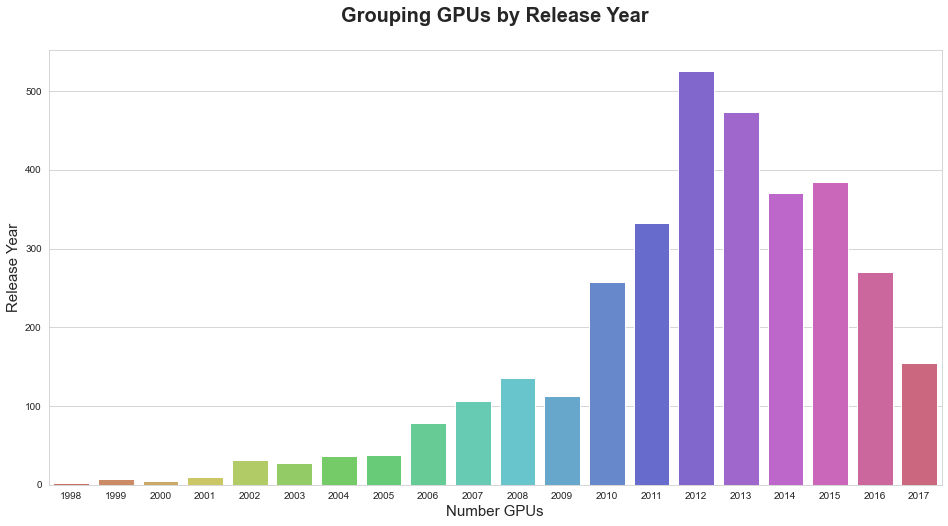

In [99]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
sns.countplot(x="Release_Year", data=dataset, palette="hls");
plt.title('Grouping GPUs by Release Year', fontsize=20, fontweight='bold', y=1.05,)
plt.xlabel('Number GPUs', fontsize=15)
plt.ylabel('Release Year', fontsize=15)
plt.show()

In [13]:
data = []

for manufacturer in dataset['Manufacturer'].unique():
    
    trace_dataset = dataset.loc[dataset['Manufacturer'] == manufacturer]
    
    trace = go.Scatter(
        x = trace_dataset['Release_Year'],
        y = trace_dataset['Memory'],
        mode = 'markers',
        name = manufacturer,
        marker= dict(symbol="circle",
                    size = trace_dataset['PixelNum']/100000,
                    opacity = 0.4,
                    line= dict(width=1,
                               color = 'rgb(255, 255, 255)'
                              ),
        ),
        text= dataset['Name']
    )

    data.append(trace)
    
layout = dict(title = 'GPU Memory vs Year of Release by Manufacturer',
              width=1000,
              height=800,
              paper_bgcolor='rgb(243, 243, 243)',
              plot_bgcolor='rgb(243, 243, 243)',
              yaxis = dict(title= 'GPUs Memory',
                           ticklen= 5,
                           gridcolor='rgb(255, 255, 255)',
                           gridwidth= 2),
              xaxis = dict(title= 'Year of Release',
                           ticklen= 5,
                           gridcolor='rgb(255, 255, 255)',
                           gridwidth= 2)
             )

fig= go.Figure(data=data, layout=layout)
py.iplot(fig)

In [14]:
# Transformed dataset - counting how many GPUs were made by each manufacturer each year
market_share = dataset.reset_index().groupby(['Release_Year','Manufacturer'])["index"].count().reset_index(name="count")
# Transformed dataset - counting how many GPUs were made each year
market_share['Sum_By_Year']  = market_share['count'].groupby(market_share["Release_Year"]).transform('sum')
# List that will hold our data dictionaries
data = []

markers = [
    dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    ),
    dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    ),
    dict(
        color='rgba(0, 168, 107, 0.7)',
        line=dict(
            color='rgba(0, 168, 107, 1.0)',
            width=2,
        )
    ),
    dict(
        color='rgba(250, 92, 0, 0.7)',
        line=dict(
            color='rgba(250, 92, 0, 1.0)',
            width=2,
        )
    )
]

for i, manufacturer in enumerate(dataset['Manufacturer'].unique()):
    
    trace_dataset = market_share.loc[market_share['Manufacturer'] == manufacturer]
    
    
    trace = go.Bar(
        x = trace_dataset['Release_Year'],
        y = round(trace_dataset['count'] / trace_dataset['Sum_By_Year'] * 100, 2),
        name= manufacturer,
        marker = markers[i],
    )
    
    data.append(trace)
    
layout = go.Layout(
    barmode='stack',
    title = 'GPU manufacturers market share',
    width=1000,
    height=500,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    yaxis = dict(title= 'Manufacturers market share [%]'),
    xaxis = dict(title= 'Manufacturers')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

KeyError: 'Memory_bandwidth'

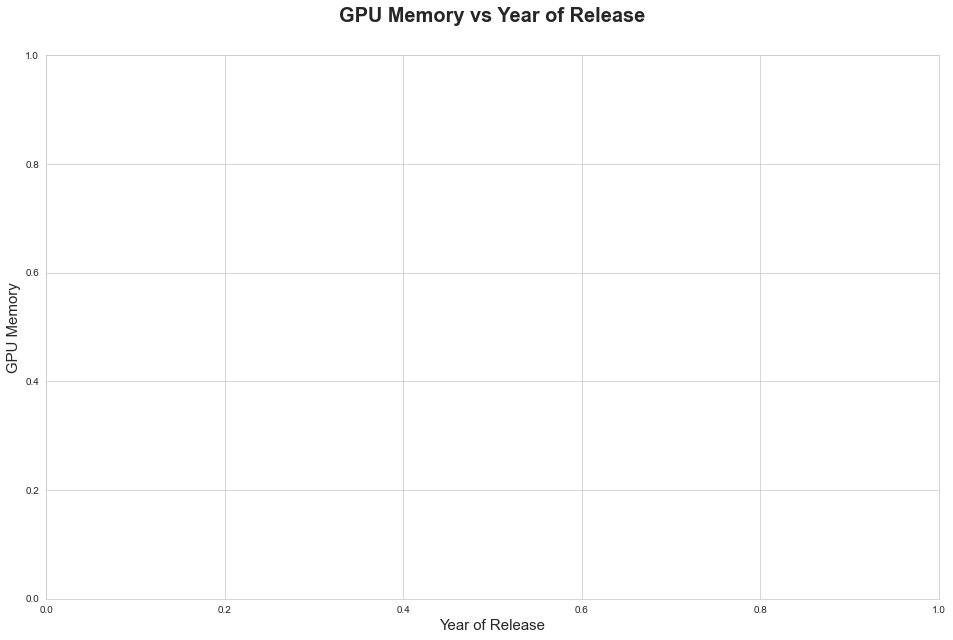

In [27]:
plt.figure(figsize=(16,10))
sns.set_style("whitegrid")
plt.title('GPU Memory vs Year of Release', fontsize=20, fontweight='bold', y=1.05,)
plt.xlabel('Year of Release', fontsize=15)
plt.ylabel('GPU Memory', fontsize=15)

years = dataset["Release"].values
memory = dataset["Memory"].values
bandwidth=dataset["Memory_bandwidth"].values

plt.scatter(years, memory, edgecolors='black')
plt.show()

In [16]:
# Numpy array that holds unique release year values
year_arr = dataset.sort_values("Release_Year")['Release_Year'].unique()
# Numpy array that holds mean values of GPUs memory for each year
memory_arr_mean = dataset.groupby('Release_Year')['Memory'].mean().values
# Numpy array that holds median values of GPUs memory for each year
memory_arr_median = dataset.groupby('Release_Year')['Memory'].median().values

# Minimal value of release year from dataset
year_min = year_arr[0]
# Median size of memory in year_min
memory_min = memory_arr_median[0]

<Figure size 432x288 with 0 Axes>

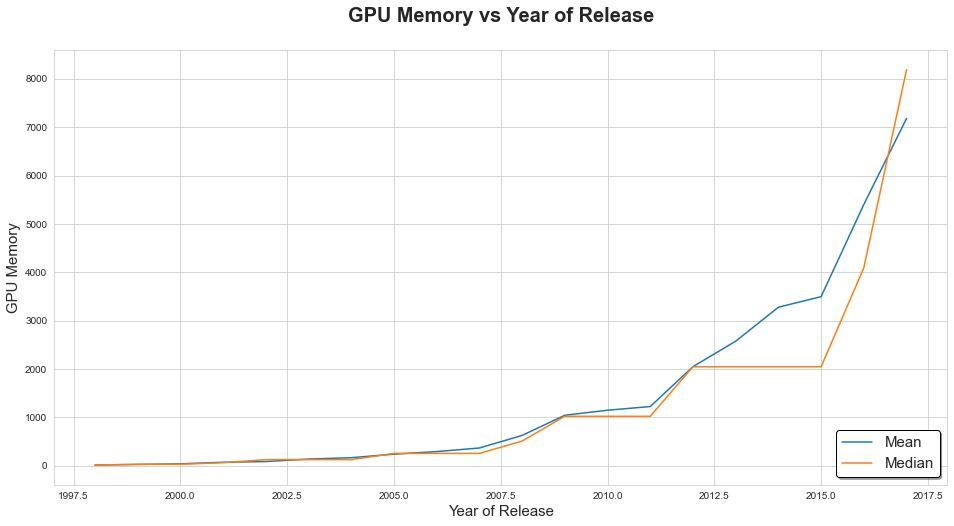

In [17]:
plt.figure()
plt.figure(figsize=(16,8))
plt.title('GPU Memory vs Year of Release', fontsize=20, fontweight='bold', y=1.05,)
plt.xlabel('Year of Release', fontsize=15)
plt.ylabel('GPU Memory', fontsize=15)
sns.set_style("whitegrid")
plt.plot(year_arr, memory_arr_mean, label="Mean")
plt.plot(year_arr, memory_arr_median, label="Median")
plt.legend(loc=4, prop={'size': 15}, frameon=True,shadow=True, facecolor="white", edgecolor="black")
plt.show()

In [18]:
# Short function to calculate size of memory based on Moore's law
def calculateMooresValue(x, y_trans):
    return memory_arr_median[0] * 2**((x-y_trans)/2)

# GPU Memory Size calculation based on Moore's Law
y_pred_moore_law_teoretic = calculateMooresValue(year_arr, int(year_min))

In [19]:
# Fitting exponential curve to dataset
def exponentialCurve(x, a, b, c):
    return a*2**((x-c)*b)

popt, pcov = curve_fit(exponentialCurve,  year_arr, memory_arr_mean,  p0=(2, 0.5, 1998))
y_pred_moore_law_fitted = exponentialCurve(year_arr, *popt)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



<Figure size 432x288 with 0 Axes>

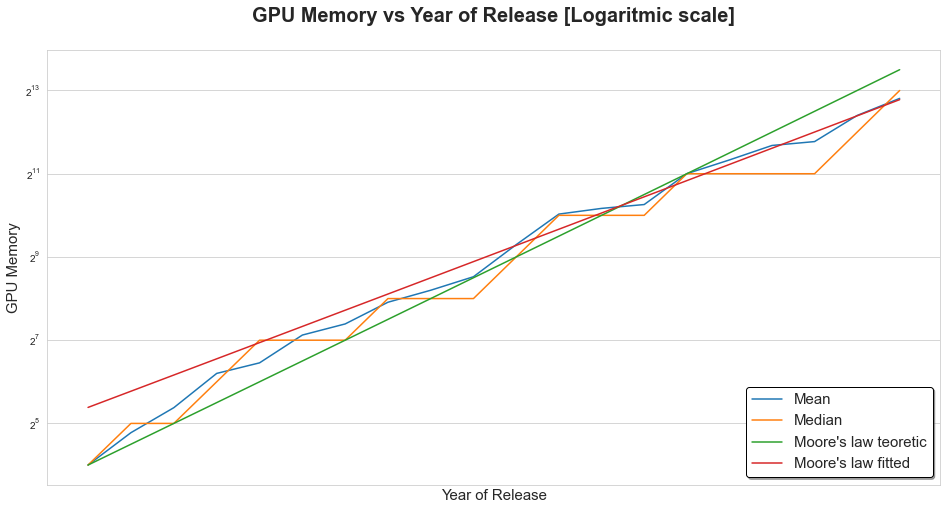

In [20]:
from email.mime import base
from sys import base_exec_prefix


plt.figure()
plt.figure(figsize=(16,8))
plt.title('GPU Memory vs Year of Release [Logaritmic scale]', fontsize=20, fontweight='bold', y=1.05,)
plt.xlabel('Year of Release', fontsize=15)
plt.ylabel('GPU Memory', fontsize=15)
sns.set_style("whitegrid")
plt.loglog(year_arr, memory_arr_mean, label="Mean", base= 2)
plt.loglog(year_arr, memory_arr_median, label="Median", base= 2)
plt.loglog(year_arr, y_pred_moore_law_teoretic, label="Moore's law teoretic", base= 2)
plt.loglog(year_arr, y_pred_moore_law_fitted, label="Moore's law fitted", base= 2)
plt.legend(loc=4, prop={'size': 15}, frameon=True,shadow=True, facecolor="white", edgecolor="black")
plt.show()

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Fitting Polynomial Regression to the dataset
poly_reg_2 = PolynomialFeatures(degree = 2, include_bias=False)
poly_reg_3 = PolynomialFeatures(degree = 3, include_bias=False)
poly_reg_4=PolynomialFeatures(degree = 2, include_bias=False)
poly_reg_5=PolynomialFeatures(degree  =3, include_bias=False)

X_poly_2 = poly_reg_2.fit_transform(year_arr.reshape(-1, 1))
X_poly_3 = poly_reg_3.fit_transform(year_arr.reshape(-1, 1))

lin_reg_2 = LinearRegression()
lin_reg_3 = LinearRegression()

lin_reg_2.fit(X_poly_2, memory_arr_mean)
lin_reg_3.fit(X_poly_3, memory_arr_mean)

y_pred_lin_reg_2 = lin_reg_2.predict(poly_reg_2.fit_transform(year_arr.reshape(-1, 1)))
y_pred_lin_reg_3 = lin_reg_3.predict(poly_reg_3.fit_transform(year_arr.reshape(-1, 1)))

In [22]:
from sklearn.metrics import r2_score

# 2nd degree curve
score = r2_score(y_pred_lin_reg_2, memory_arr_mean)
print("r2 of 2nd degree curve is equal " + str(round(score, 3)))
# 3rd degree curve
score = r2_score(y_pred_lin_reg_3, memory_arr_mean)
print("r2 of 3rd degree curve is equal " + str(round(score, 3)))
# Teoretic Moore's Law curve
score = r2_score(y_pred_moore_law_teoretic, memory_arr_mean)
print("r2 of Teoretic Moore's Law curve is equal " + str(round(score, 3)))
# Fitted Moore's Law curve
score = r2_score(y_pred_moore_law_fitted, memory_arr_mean)
print("r2 of Fitted Moore's Law curve is equal " + str(round(score, 3)))

r2 of 2nd degree curve is equal 0.947
r2 of 3rd degree curve is equal 0.985
r2 of Teoretic Moore's Law curve is equal 0.825
r2 of Fitted Moore's Law curve is equal 0.992


In [25]:
memory_2025 = exponentialCurve(2011, *popt)

In [26]:
print(f"Predicted mean size of GPU memory is " + str(round(int(memory_2025) / 1024, 2)) + " GB.")

Predicted mean size of GPU memory is 1.36 GB.
